In [1]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC


from MetropolisHastings import MetropolisHastingsSampler,MoreauYosidaPrior
from FEM_Solver import  RootFinder,FEMSolver
from utilities import *

import numpy as np
import matplotlib.pyplot as plt

from NN import DNN
from GaLa import llaplace
from GaLa2 import llaplace as llaplace2

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tiaming Experiment 3

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{2} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

## Computing Roots

In [2]:
lam = 1 / 4
M = 2

finder = RootFinder(lam, M)
roots = finder.find_roots()

print("Roots:", roots)

Roots: [2.15374797 4.57785946]


In [3]:
def k_function(data_domain,w=roots):
    
    x = data_domain[:,0].reshape(-1,1)
    theta = data_domain[:,1:].reshape(x.shape[0],-1)

    A = torch.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (torch.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (torch.cos(2*w)/8)))
    
    bn =  A*(torch.sin(w*x) + ((w)/(4))*torch.cos(w*x))

    an = torch.sqrt(8 / (w**2 + 16))

    return torch.sum(an*bn*theta,dim=1)

def de(self,data_domain,k = k_function,roots = torch.tensor(roots,dtype=float).reshape(1,-1)):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)

    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    k = k(data_domain,roots)
    
    ddu_x = torch.autograd.grad(
        torch.exp(k).reshape(-1,1)*du[:,0].reshape(-1,1),data_domain, 
        grad_outputs=torch.ones_like(du[:,0].reshape(-1,1)),
        retain_graph=True,
        create_graph=True
        )[0]
        
    return ddu_x[:,0].reshape(-1,1) + 4*data_domain[:,0].reshape(-1,1)


def bc_l(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)

def bc_r(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)- 2

DNN.de = de
DNN.bc_l = bc_l
DNN.bc_r = bc_r

In [4]:
# Number of observations
epochs = 500

N = [150,500,1000,1500,2000,2500]
sample_size = [50,75,125,150]
weights = [5,10,20,50]
hidden_layers = [1,2,3]
    
lr = 0.01

In [5]:
# torch.manual_seed(42)

# data_parameters = samples_param(5000, nparam=2)
# param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

# for hl in [3]:
#     for w in weights:
#         for nobs in N:
#             dataset = dGDataset(size = nobs, param=param_train)

#             x_val,param_val, sol_val = generate_test_data(nobs,param =param_test, vert=30)

#             for ss in sample_size:
#                     layers = [3] + hl*[w] + [1]
                    
#                     model = DNN(layers)

#                     dataloader = DataLoader(dataset, batch_size=ss, shuffle=False)

#                     loss = torch.nn.MSELoss(reduction ='mean')

#                     optimizer = torch.optim.Adam(model.parameters(), lr = lr)

#                     loss_adam = train_adam(dataloader,model, loss, optimizer, epochs,param_val,x_val,sol_val, device)


#                     np.save(f'./Models/adam_only_train_hiddenl{hl}_w{w}_N{nobs}_batch{ss}.npy', loss_adam[0])
#                     np.save(f'./Models/adam_only_test_hiddenl{hl}_w{w}_N{nobs}_batch{ss}.npy', loss_adam[1]) 

#                     path = f"./Models/1dElliptic_adam_PDE2_hiddenl{hl}_w{w}_N{nobs}_batch{ss}.pt"
#                     torch.save(model.state_dict(),path)

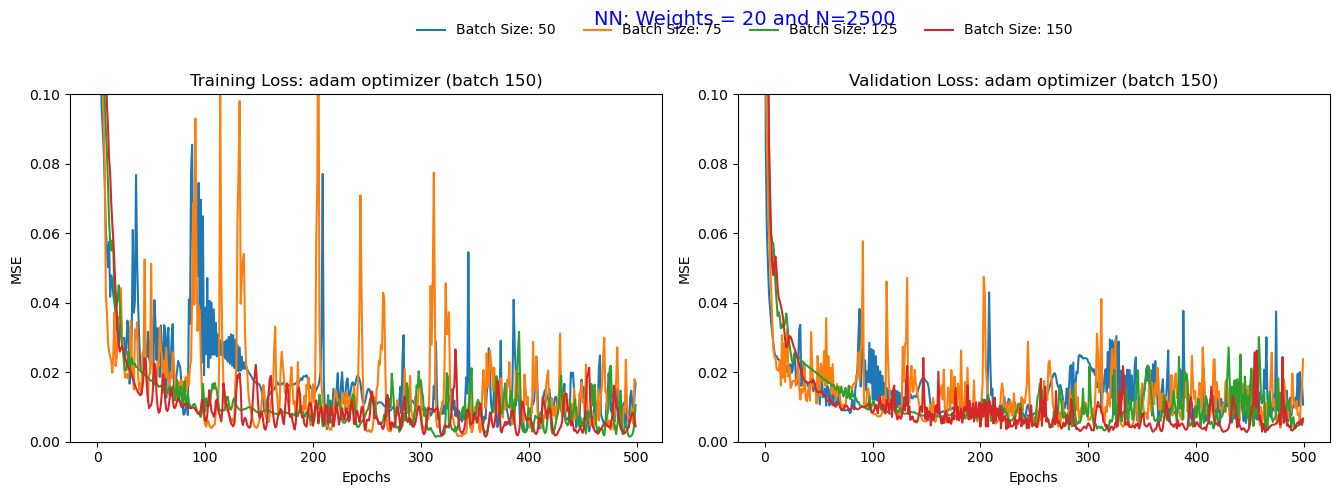

In [6]:
hl, w,nobs =  3,20,2500

plot_loss_dynamics(hl, w, nobs, sample_size, adltrain=0.1, adltest=0.1)

# Error Analysis

In [7]:
ntest, vert = 1500, 30

x_test,param_test, sol_test = generate_test_data(ntest, vert=vert)

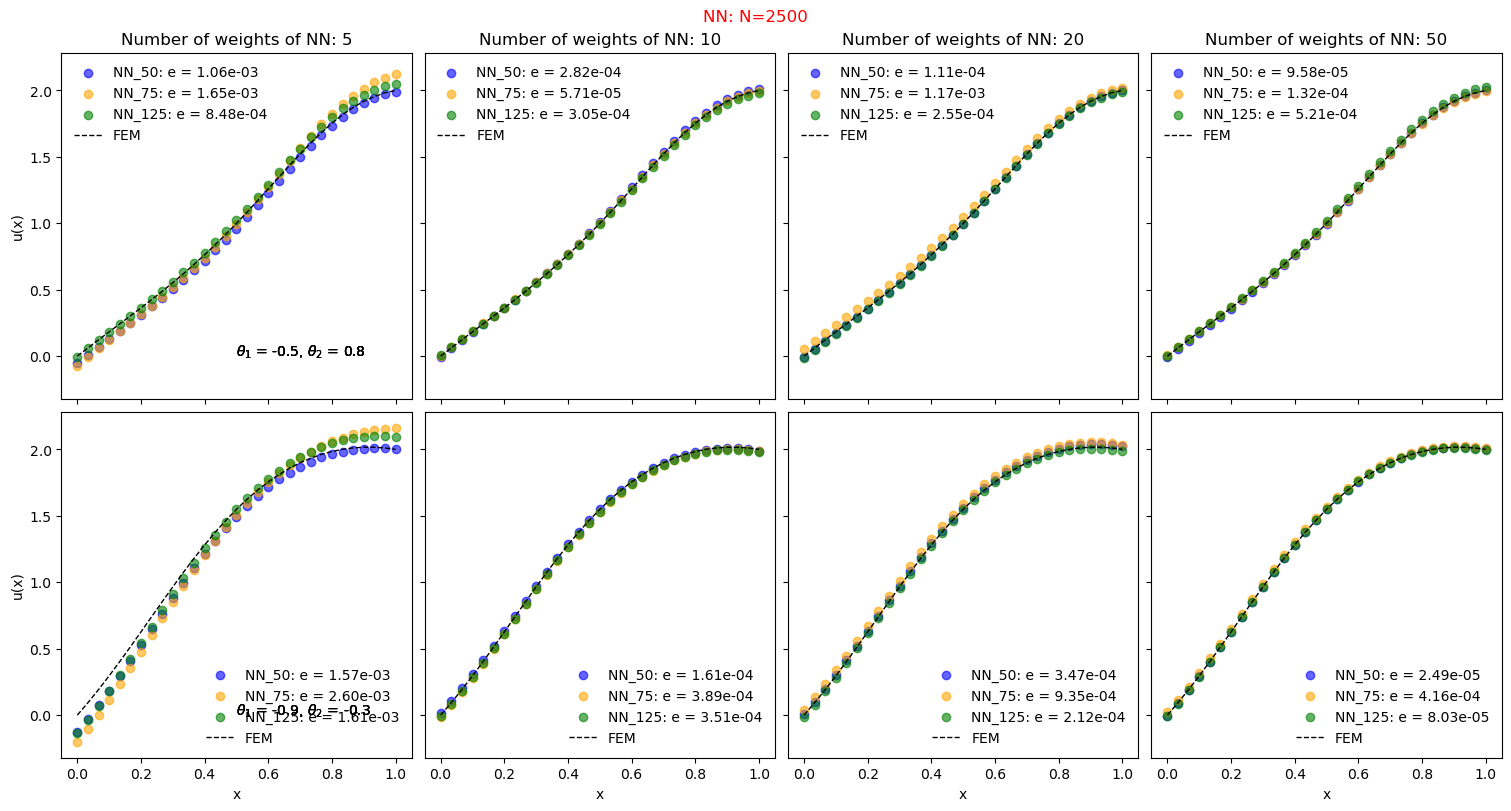

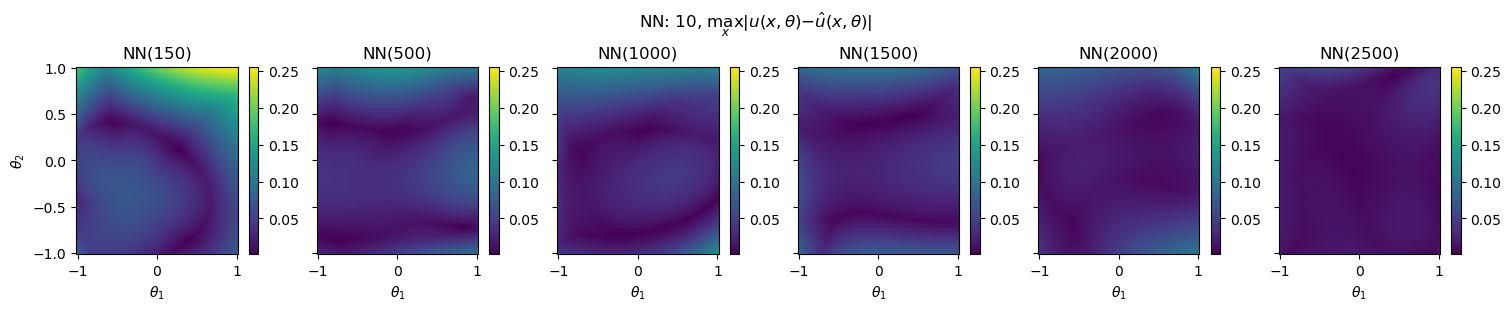

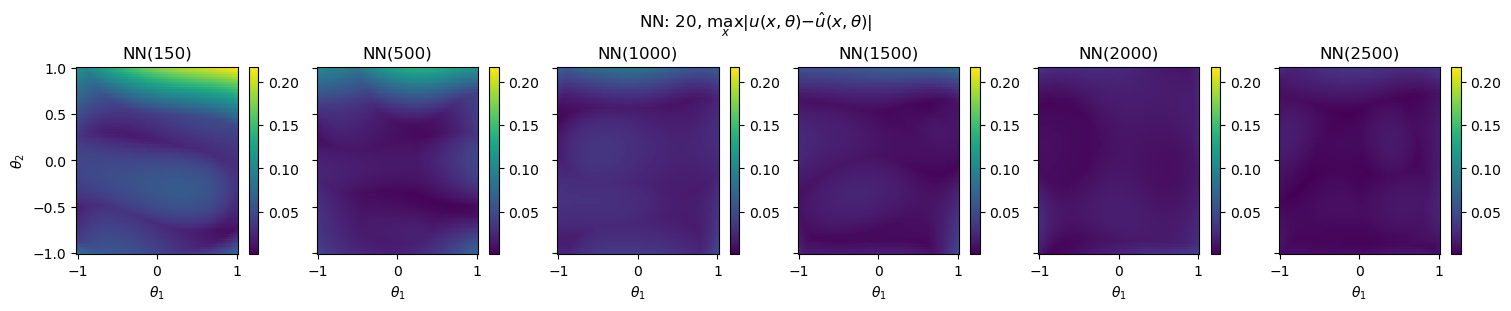

In [12]:
path = "./Models/1dElliptic_adam_PDE2_hiddenl2_w{w}_N{nobs}_batch{ss}.pt"

plot_nn_vs_fem(weights, param_test, x_test, sol_test, sample_size,path ,DNN, nobs=2500,hn=2)

grid = 75

# Initialize arrays to store mean and variance results
res_mean = np.zeros((len(weights), len(N), len(hidden_layers)))
res_var = np.zeros((len(weights), len(N), len(hidden_layers)))

relative_mean = np.zeros((len(weights), len(N), len(hidden_layers)))
relative_var = np.zeros((len(weights), len(N), len(hidden_layers)))

# Loop over hidden layers (hl), weights (wg), and N
for j, hl in enumerate(hidden_layers):
    for k, wg in enumerate(weights):
        # Call compute_max_error with the given parameters
        results, X, Y = compute_max_error(N, wg,hn=j+1, grid=grid, 
                                          model_dir='./Models/', 
                                          model_prefix=f'1dElliptic_adam_PDE2_hiddenl{j+1}', 
                                          batch=150,vert=200)

        res_mean[k, :, j] = results.mean(axis=(0,1))
        res_var[k, :, j] = results.var(axis=(0,1))


        # results2, X, Y = compute_relative_error(N, wg,hn=j+1, grid=grid, 
        #                                   model_dir='./Models/', 
        #                                   model_prefix=f'1dElliptic_adam_PDE2_hiddenl{j+1}', 
        #                                   batch=150,vert=200)

        # relative_mean[k, :, j] = results2.mean(axis=(0,1))
        # relative_var[k, :, j] = results2.var(axis=(0,1))

        # Conditional plotting for specific hidden layer and weight
        if (hl == 2 and wg == 20) or (hl == 2 and wg == 10):
            plot_max_errors(N, results, X, Y, wg)

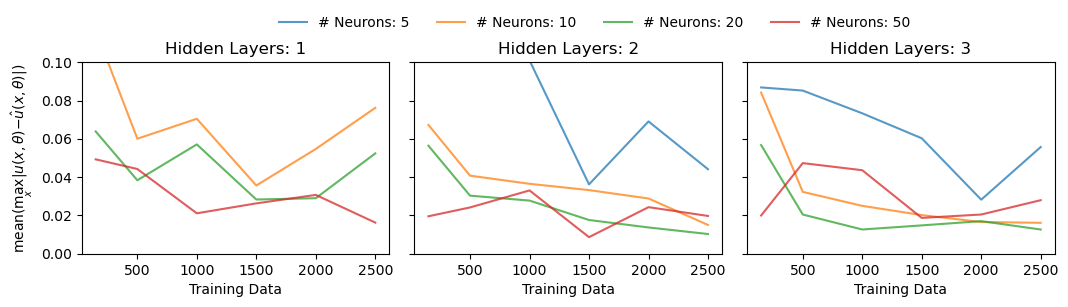

In [13]:
fig, axs = plt.subplots(1, len(hidden_layers), figsize=(12, 3), sharey=True,layout="constrained")

for j, hl in enumerate(hidden_layers):
    for k, wg in enumerate(weights):
        axs[j].plot(N,res_mean[k,:,j], label = f"# Neurons: {wg}",alpha = 0.75)
        axs[j].set_xlabel("Training Data"), axs[0]. set_ylabel(r"mean($\max_{{x}} | u(x, \theta) - \hat{{u}}(x, \theta)|$)")
        axs[j].set_title(f"Hidden Layers: {j+1}")

axs[0].set_ylim((0,0.1))
# Add a global legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=len(sample_size), frameon=False, fontsize=10)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

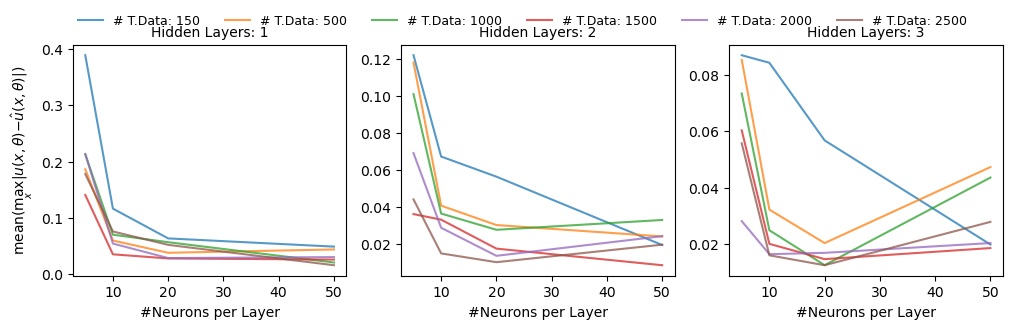

In [14]:
fig, axs = plt.subplots(1, len(hidden_layers), figsize=(12, 3))

for j, hl in enumerate(hidden_layers):
    for k, nobs in enumerate(N):
        axs[j].plot(weights,res_mean[:,k,j], label = f"# T.Data: {nobs}",alpha = 0.75)
        axs[j].set_xlabel("#Neurons per Layer"), axs[0]. set_ylabel(r"mean($\max_{{x}} | u(x, \theta) - \hat{{u}}(x, \theta)|$)")
        axs[j].set_title(f"Hidden Layers: {j+1}", fontsize = 10)

# Add a global legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=len(N), frameon=False, fontsize=9)

In [6]:
nobs, hl, w = 500, 2, 20

layers = [3] + 2*[20] + [1]

model = DNN(layers).to(device)
model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_hiddenl{hl}_w{w}_N{nobs}_batch150.pt"))
model.eval()

##### Deep GaLA
data_int,left_bc,right_bc = generate_data(nobs)
data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

pde = {"PDE":["de","bc_l","bc_r"], 
    "data_set":{"de" : Variable(data_int,requires_grad=True),
    "bc_l":left_bc,
    "bc_r" :right_bc}}

llp2 = llaplace2(model)

llp2.fit(pde=pde, hessian_structure = "full")

llp2.optimize_marginal_likelihood(max_iter=300)

Iteration 100, Error: 0.00852, neg_marglik: 526.95911
Iteration 200, Error: 0.00501, neg_marglik: 145.11911
Iteration 300, Error: 0.00125, neg_marglik: 27.35854
Maximum iterations (300)reached, sigma : 0.23916243016719818, prior: 11.504440307617188.


In [7]:
ntest, vert = 1500, 30

x_test,param_test, sol_test = generate_test_data(ntest, vert=vert)

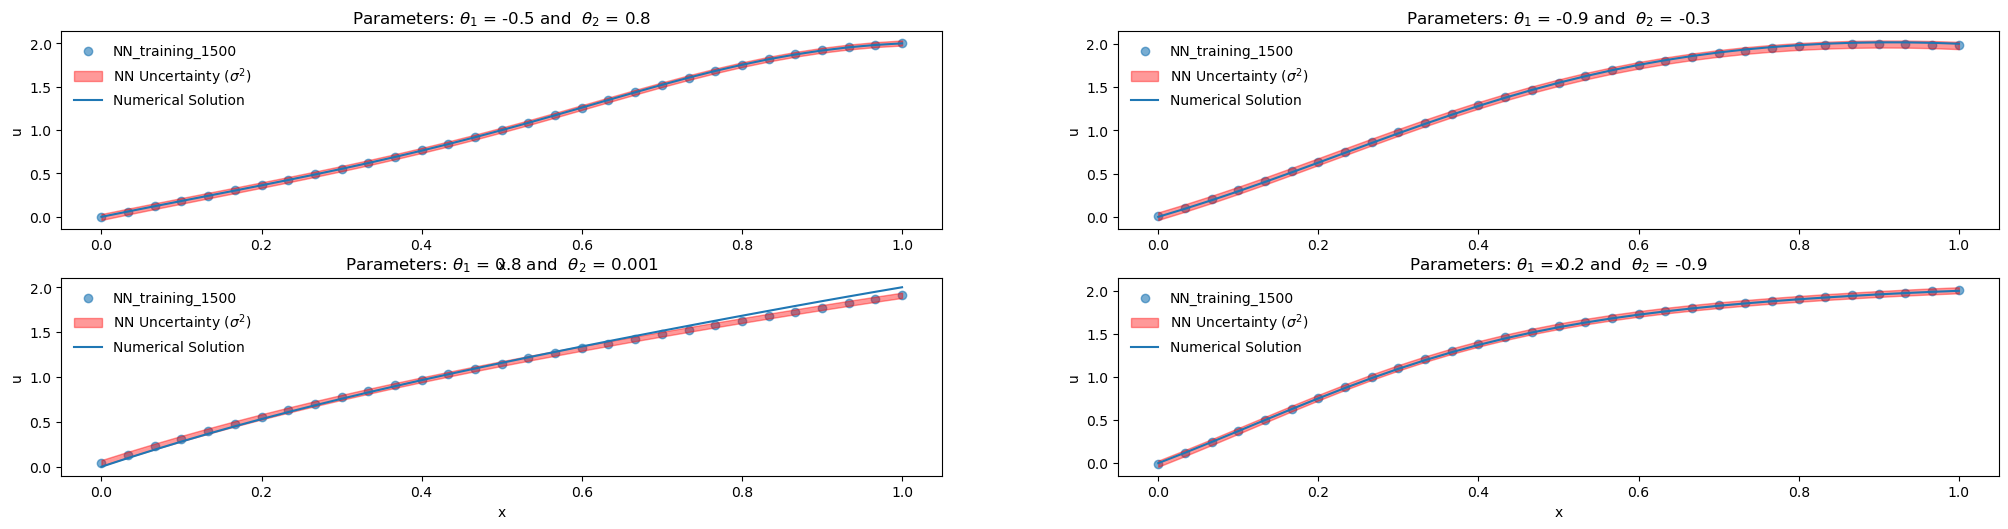

In [8]:
# Plotting
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.25)
colors = ["blue","orange","green"]

for n,(pr1) in enumerate(param_test[:4]):

    data_test = torch.tensor(np.hstack((x_test, np.ones((x_test.shape[0],pr1.shape[0]))*(pr1)))).float()
    numerical_sol = sol_test[n,:]

    plt.subplot(8, 2, n + 1)

    u_mean, u_sigma = llp2(data_test)
    u_mean, u_sigma = u_mean.detach().cpu().numpy(), u_sigma[:,:,0].sqrt().detach().cpu().numpy()
    numerical_sol = numerical_sol.reshape(u_mean.shape)

    plt.scatter(x_test, u_mean, label = fr"NN_training_{1500}",alpha=0.6 )
    plt.fill_between(x_test.reshape(-1), (u_mean+2*u_sigma).reshape(-1),(u_mean-2*u_sigma).reshape(-1),alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")

    plt.plot(x_test, numerical_sol, label = "Numerical Solution")

    plt.title(fr"Parameters: $\theta_{1}$ = {pr1[0]:.1g} and  $\theta_{2}$ = {pr1[1]:.1g}")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend(frameon=False)

In [14]:
nobs, hl, w = 2500, 2, 20

layers = [3] + 2*[20] + [1]

model = DNN(layers).to(device)
model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_hiddenl{hl}_w{w}_N{nobs}_batch150.pt"))
model.eval()

##### Deep GaLA
data_int,left_bc,right_bc = generate_data(nobs)
data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

pde = {"PDE":["de","bc_l","bc_r"], 
    "data_set":{"de" : Variable(data_int,requires_grad=True),
    "bc_l":left_bc,
    "bc_r" :right_bc}}

llp3 = llaplace2(model)

llp3.fit(pde=pde, hessian_structure = "full")

llp3.optimize_marginal_likelihood(max_iter=100)

Iteration 100, Error: 0.00896, neg_marglik: 2400.52686
Maximum iterations (100)reached, sigma : 1.0110183954238892, prior: 6.832572937011719.


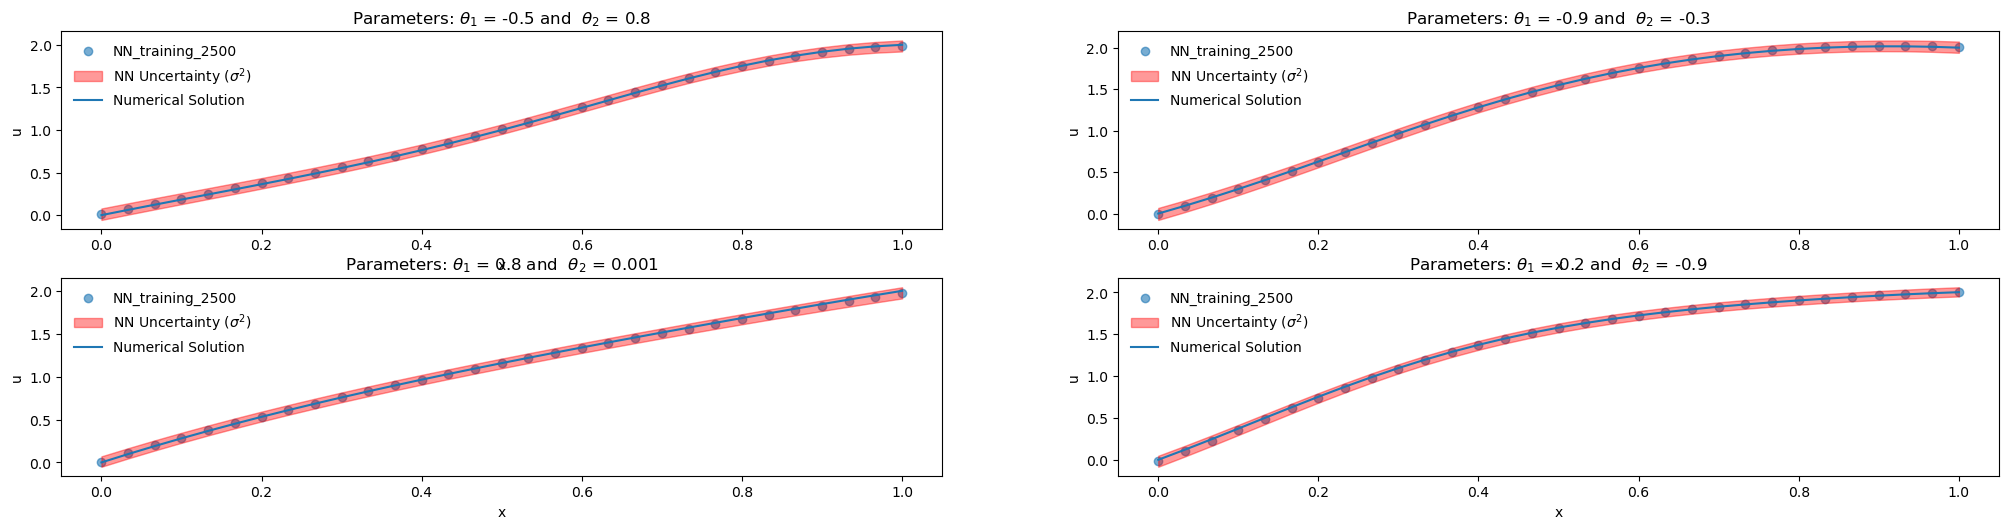

In [15]:
# Plotting
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.25)
colors = ["blue","orange","green"]

for n,(pr1) in enumerate(param_test[:4]):

    data_test = torch.tensor(np.hstack((x_test, np.ones((x_test.shape[0],pr1.shape[0]))*(pr1)))).float()
    numerical_sol = sol_test[n,:]

    plt.subplot(8, 2, n + 1)

    u_mean, u_sigma = llp3(data_test)
    u_mean, u_sigma = u_mean.detach().cpu().numpy(), u_sigma[:,:,0].sqrt().detach().cpu().numpy()
    numerical_sol = numerical_sol.reshape(u_mean.shape)

    plt.scatter(x_test, u_mean, label = fr"NN_training_{2500}",alpha=0.6 )
    plt.fill_between(x_test.reshape(-1), (u_mean+2*u_sigma).reshape(-1),(u_mean-2*u_sigma).reshape(-1),alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")

    plt.plot(x_test, numerical_sol, label = "Numerical Solution")

    plt.title(fr"Parameters: $\theta_{1}$ = {pr1[0]:.1g} and  $\theta_{2}$ = {pr1[1]:.1g}")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend(frameon=False)

# Pyro Uniform

# Inverse problem through MCMC

In [15]:
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
import torch
from FEM_Solver import  FEMSolver


# Define the model using a coarse FEM solver
def model(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):
    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))


    # Use a coarse mesh FEM solver as the surrogate model
    surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

    surrogate_fem_solver.uh = None

    surrogate_fem_solver.solve()

    # Get model predictions at the given points
    model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y


def model_dgala(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu, surg_sigma = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

    sigma = sig ** 2 + surg_sigma

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

def model_nn(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

In [16]:
theta_th=np.array([0.098, 0.430])
solver = FEMSolver(theta_th, vert=320)
solution = solver.solve()

dy = 6
X = np.linspace(0.2,0.8,dy).reshape(-1,1)

#y = solver.eval_at_points(X)


np.random.seed(0)
k = 4
dy = 6
eta = np.random.normal(0,10**(-k/2),dy)

y_tia = np.array([4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00])
y = y_tia + eta

y = y.reshape(-1,1)
y

array([[0.44335802],
       [0.67442523],
       [0.93192104],
       [1.20755997],
       [1.47036749],
       [1.69056285]])

In [17]:
import time

theta_th=np.array([0.098, 0.430])
vr = 1e-4
st = torch.sqrt(torch.tensor(vr))
hvert = 50

#obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)

obs_points, obs_sol = torch.tensor(X), torch.tensor(y)
# Define the MCMC kernel (using Random Walk Metropolis)

st = torch.sqrt(torch.tensor(vr).float().to(device))    
# Define the MCMC kernel (using Random Walk Metropolis)
kernel = mcmc.RandomWalkKernel(model, target_accept_prob=0.234)

# Create an MCMC object with the kernel
mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

surrogate_fem_solver = FEMSolver(theta=np.zeros(theta_th.shape[0]), vert=hvert)

# Run the MCMC inference
mcmc_sampler.run(surrogate_fem_solver,obs_sol, obs_points,st)

# Get the results (posterior samples)
samples = mcmc_sampler.get_samples()
samples = samples["theta"].numpy()

np.save(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{10}_tiaming.npy', samples)


obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)

st = torch.sqrt(torch.tensor(vr))
layers = [3] + 2*[20] + [1]

for nobs in [150,500,2500]:
    model = DNN(layers).to(device)
    model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_hiddenl{2}_w{20}_N{nobs}_batch150.pt"))
    model.eval()

    kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

    mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

    mcmc_sampler.run(model,obs_sol,obs_points,st)

    # Get the results (posterior samples)
    samples = mcmc_sampler.get_samples()
    samples = samples["theta"].numpy()

    np.save(f'./Models/NN_var{vr}_hl{2}_w{20}_{nobs}_Samples_tiaming.npy', samples)
    del kernel, mcmc_sampler, samples

    ##### Deep GaLA
    data_int,left_bc,right_bc = generate_data(nobs)
    data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

    pde = {"PDE":["de","bc_l","bc_r"], 
        "data_set":{"de" : Variable(data_int,requires_grad=True),
        "bc_l":left_bc,
        "bc_r" :right_bc}}
    
    llp2 = llaplace2(model)

    start_time_mh = time.time()  # Start timing
    llp2.fit(pde=pde, hessian_structure = "full")
    end_time_mh = time.time()  # End timing
    print(f"Total time for fitting: {(end_time_mh-start_time_mh)/60 }")

    start_time_mh = time.time()  # Start timing
    llp2.optimize_marginal_likelihood(max_iter=100)
    end_time_mh = time.time()  # End timing
    print(f"Total time for optimizing: {(end_time_mh-start_time_mh)/60 }")

    kernel = mcmc.RandomWalkKernel(model_dgala, target_accept_prob=0.234)

    mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

    mcmc_sampler.run(llp2,torch.tensor(obs_sol).float().to(device),
                    torch.tensor(obs_points).float().to(device),
                    torch.sqrt(torch.tensor(vr).float().to(device)))

    # Get the results (posterior samples)
    samples = mcmc_sampler.get_samples()
    samples = samples["theta"].numpy()

    np.save(f'./Models/dGaLA2_hl{2}_w{20}_var{vr}_{nobs}_Samples_tiaming.npy', samples)
    del kernel, mcmc_sampler, samples

Sample: 100%|██████████| 1005000/1005000 [06:41, 2503.83it/s, step size=1.05e-01, acc. prob=0.231]


Total time for fitting: 0.007109646002451579
Iteration 100, Error: 0.00806, neg_marglik: 174.93130
Maximum iterations (100)reached, sigma : 1.0163755416870117, prior: 6.449173927307129.
Total time for optimizing: 0.13964646657307941


Sample: 100%|██████████| 1005000/1005000 [06:42, 2494.73it/s, step size=1.10e-01, acc. prob=0.238]


Total time for fitting: 0.01729376713434855
Iteration 100, Error: 0.00852, neg_marglik: 526.95917
Maximum iterations (100)reached, sigma : 1.0163276195526123, prior: 6.675427436828613.
Total time for optimizing: 0.37452843189239504


Sample: 100%|██████████| 1005000/1005000 [06:44, 2484.98it/s, step size=1.20e-01, acc. prob=0.226]


Total time for fitting: 0.6054858406384785
Iteration 100, Error: 0.00896, neg_marglik: 2400.52686
Maximum iterations (100)reached, sigma : 1.0110183954238892, prior: 6.832572937011719.
Total time for optimizing: 12.776366023222606


Sample: 100%|██████████| 1005000/1005000 [18:25, 909.18it/s, step size=2.82e-01, acc. prob=0.233]


(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

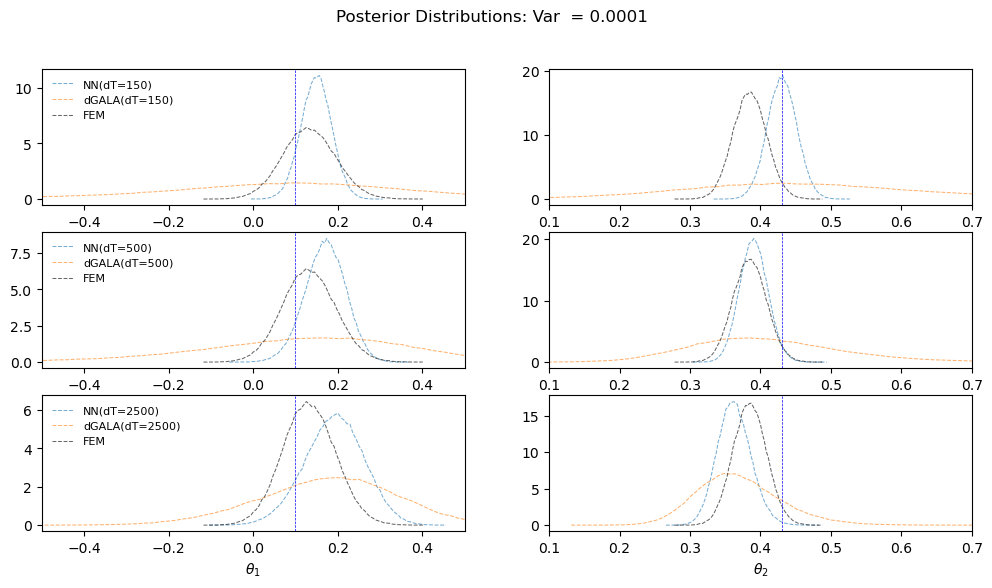

In [33]:
fig, axs = plt.subplots(3, 2, figsize=(12, 6))
fig.suptitle(f"Posterior Distributions: Var  = {vr}")
bins =80

for i,nobs in  enumerate([150,500,2500]):

    sample = np.load(f'./Models/NN_var{vr}_hl{2}_w{20}_{nobs}_Samples_tiaming.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    sample = np.load(f'./Models/dGaLA2_hl{2}_w{20}_var{vr}_{nobs}_Samples_tiaming.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    

    sample = np.load(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{10}_tiaming.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

    axs[i,1].set_xlim((0.1,0.7)),axs[i,0].set_xlim((-0.5,0.5))

axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")



In [16]:
import time

theta_th=np.array([0.098, 0.430])
vr = 0.001
st = np.sqrt(vr)

obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)
obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)

st = torch.sqrt(torch.tensor(vr))
layers = [3] + 2*[20] + [1]

# for nobs in [150,500,2500]:
#     model = DNN(layers).to(device)
#     model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_hiddenl{2}_w{20}_N{nobs}_batch150.pt"))
#     model.eval()

#     kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(model,obs_sol,obs_points,st)

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/NN_var{vr}_hl{2}_w{20}_{nobs}_Samples_.npy', samples)
#     del kernel, mcmc_sampler, samples

#     ##### Deep GaLA
#     data_int,left_bc,right_bc = generate_data(nobs)
#     data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

#     pde = {"PDE":["de","bc_l","bc_r"], 
#         "data_set":{"de" : Variable(data_int,requires_grad=True),
#         "bc_l":left_bc,
#         "bc_r" :right_bc}}
    
#     llp2 = llaplace2(model)

#     start_time_mh = time.time()  # Start timing
#     llp2.fit(pde=pde, hessian_structure = "full")
#     end_time_mh = time.time()  # End timing
#     print(f"Total time for fitting: {(end_time_mh-start_time_mh)/60 }")

#     start_time_mh = time.time()  # Start timing
#     llp2.optimize_marginal_likelihood(max_iter=100)
#     end_time_mh = time.time()  # End timing
#     print(f"Total time for optimizing: {(end_time_mh-start_time_mh)/60 }")

#     kernel = mcmc.RandomWalkKernel(model_dgala, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(llp2,torch.tensor(obs_sol).float().to(device),
#                     torch.tensor(obs_points).float().to(device),
#                     torch.sqrt(torch.tensor(vr).float().to(device)))

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/dGaLA2_hl{2}_w{20}_var{vr}_{nobs}_Samples_.npy', samples)
#     del kernel, mcmc_sampler, samples

Sample: 100%|██████████| 1005000/1005000 [07:04, 2366.71it/s, step size=2.84e-01, acc. prob=0.251]


Total time for fitting: 0.0042759458223978674
Iteration 100, Error: 0.00806, neg_marglik: 174.93130
Maximum iterations (100)reached, sigma : 1.0163755416870117, prior: 6.449173927307129.
Total time for optimizing: 0.12004878918329874


Sample: 100%|██████████| 1005000/1005000 [07:01, 2385.55it/s, step size=3.50e-01, acc. prob=0.237]


Total time for fitting: 0.01538691520690918
Iteration 100, Error: 0.00852, neg_marglik: 526.95917
Maximum iterations (100)reached, sigma : 1.0163276195526123, prior: 6.675427436828613.
Total time for optimizing: 0.3452139973640442


Sample: 100%|██████████| 1005000/1005000 [06:47, 2464.55it/s, step size=3.51e-01, acc. prob=0.247]


Total time for fitting: 0.5972705642382304
Iteration 100, Error: 0.00896, neg_marglik: 2400.52686
Maximum iterations (100)reached, sigma : 1.0110183954238892, prior: 6.832572937011719.
Total time for optimizing: 11.525583028793335


Sample: 100%|██████████| 1005000/1005000 [19:19, 866.72it/s, step size=4.39e-01, acc. prob=0.240]


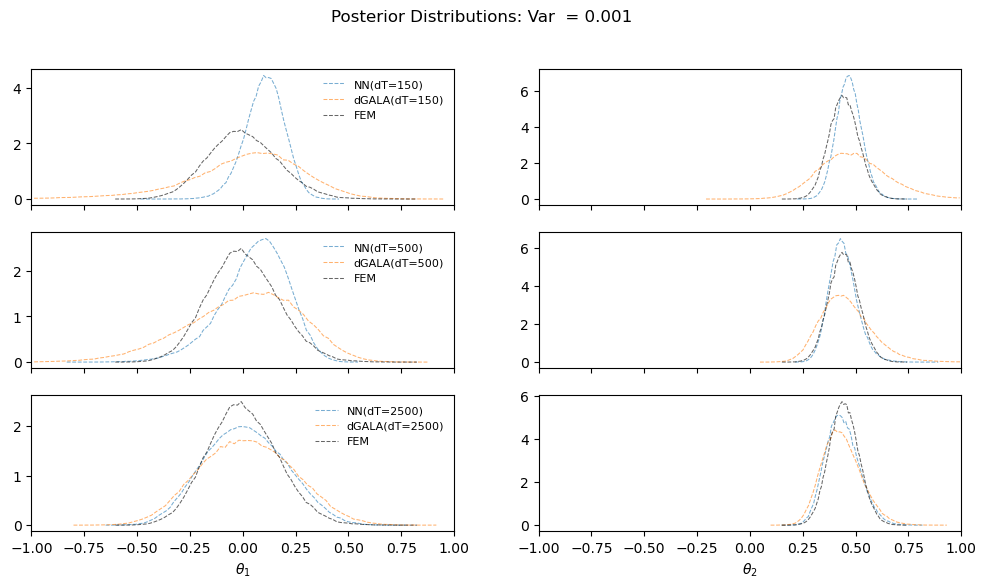

In [17]:
bins =80
#vr = 0.001
vr = 0.001
fig, axs = plt.subplots(3, 2, figsize=(12, 6),sharex=True)
fig.suptitle(f"Posterior Distributions: Var  = {vr}")

for i,nobs in  enumerate([150,500,2500]):

    sample = np.load(f'./Models/NN_var{vr}_hl{2}_w{20}_{nobs}_Samples_.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")


    sample = np.load(f'./Models/dGaLA2_hl{2}_w{20}_var{vr}_{nobs}_Samples_.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    

    sample = np.load(f'./Models/FEM_pyro_h50_var{vr}_obs10.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)

    axs[i,0].set_xlim(-1,1),axs[i,1].set_xlim(-1,1)
    axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")



In [47]:
theta_th=np.array([0.098, 0.430])
vr = 0.001
st = np.sqrt(vr)

obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)
obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)
st = torch.sqrt(torch.tensor(vr))
layers = [3] + 2*[10] + [1]

nobs = 150
model = DNN(layers).to(device)
model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_hiddenl{2}_w{10}_N{nobs}_batch150.pt"))
model.eval()

kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

mcmc_sampler.run(model,obs_sol,obs_points,st)

# Get the results (posterior samples)
samples = mcmc_sampler.get_samples()
samples = samples["theta"].numpy()

np.save(f'./Models/NN_var{vr}_hl{2}_w{10}_{nobs}_Samples_.npy', samples)
del kernel, mcmc_sampler, samples

##### Deep GaLA
data_int,left_bc,right_bc = generate_data(nobs)
data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

pde = {"PDE":["de","bc_l","bc_r"], 
    "data_set":{"de" : Variable(data_int,requires_grad=True),
    "bc_l":left_bc,
    "bc_r" :right_bc}}

llp2 = llaplace2(model)

start_time_mh = time.time()  # Start timing
llp2.fit(pde=pde, hessian_structure = "full")
end_time_mh = time.time()  # End timing
print(f"Total time for fitting: {(end_time_mh-start_time_mh)/60 }")

start_time_mh = time.time()  # Start timing
llp2.optimize_marginal_likelihood(max_iter=100)
end_time_mh = time.time()  # End timing
print(f"Total time for optimizing: {(end_time_mh-start_time_mh)/60 }")

kernel = mcmc.RandomWalkKernel(model_dgala, target_accept_prob=0.234)

mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

mcmc_sampler.run(llp2,torch.tensor(obs_sol).float().to(device),
                torch.tensor(obs_points).float().to(device),
                torch.sqrt(torch.tensor(vr).float().to(device)))

# Get the results (posterior samples)
samples = mcmc_sampler.get_samples()
samples = samples["theta"].numpy()

np.save(f'./Models/dGaLA2_hl{2}_w{10}_var{vr}_{nobs}_Samples_.npy', samples)
del kernel, mcmc_sampler, samples

Sample: 100%|██████████| 1005000/1005000 [07:01, 2385.37it/s, step size=3.46e-01, acc. prob=0.228]


Total time for fitting: 0.0018942077954610189
Iteration 100, Error: 0.00523, neg_marglik: 175.41916
Maximum iterations (100)reached, sigma : 1.019245982170105, prior: 3.4945573806762695.
Total time for optimizing: 0.12408353487650553


Sample: 100%|██████████| 1005000/1005000 [17:48, 940.36it/s, step size=8.58e-01, acc. prob=0.260] 


(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

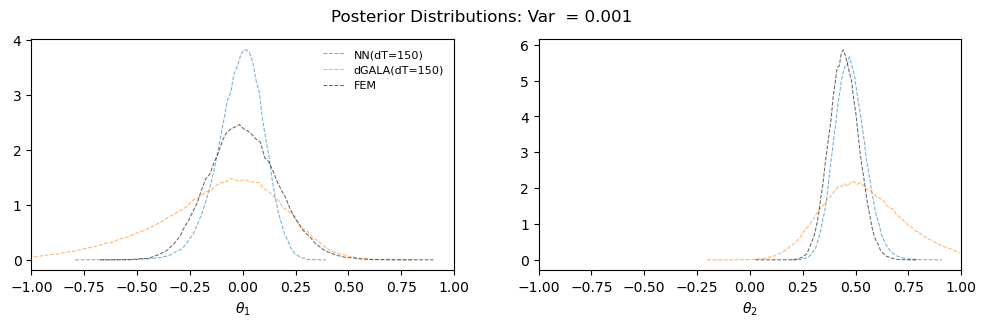

In [10]:
bins =80
vr = 0.001
nobs = 150

fig, axs = plt.subplots(1, 2, figsize=(12, 3),sharex=True)
fig.suptitle(f"Posterior Distributions: Var  = {vr}")


sample = np.load(f'./Models/NN_var{vr}_hl{2}_w{10}_{nobs}_Samples_.npy')

bin_centers, counts = histogram_(sample[:, 0],bins=bins)
axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
bin_centers, counts = histogram_(sample[:, 1],bins=bins)
axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

sample = np.load(f'./Models/dGaLA2_hl{2}_w{10}_var{vr}_{nobs}_Samples_.npy')

bin_centers, counts = histogram_(sample[:, 0],bins=bins)
axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
bin_centers, counts = histogram_(sample[:, 1],bins=bins)
axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")


sample = np.load(f'./Models/FEM_pyro_h50_var{vr}_obs10.npy')

bin_centers, counts = histogram_(sample[:, 0],bins=bins)
axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
bin_centers, counts = histogram_(sample[:, 1],bins=bins)
axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")

axs[0].legend(frameon = False, fontsize =8)

axs[0].set_xlim(-1,1),axs[1].set_xlim(-1,1)
axs[0].set_xlabel("$\\theta_{1}$"),axs[1].set_xlabel("$\\theta_{2}$")


In [ ]:
from GaLa2 import llaplace as llaplace2

obs = 10
theta_th=np.array([0.098, 0.430])
mean = 0
var = [1e-4,5e-4,1e-3,5e-3]
N = [1500,2000,2500]


# for item in [(50,1,2500),(20,2,2500)]:
#     w,hl,nobs = item
#     #### Samples From Surrogate
# layers = [3] + 1*[50] + [1]

# for vr in var:
#     st = np.sqrt(vr)
#     obs_points, obs_sol = generate_noisy_obs(obs, theta_t=theta_th, mean=mean, std=st,vert=200)
#     obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)
#     st = torch.sqrt(torch.tensor(vr))

#     for nobs in N:
#         model = DNN(layers).to(device)
#         model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_hiddenl{1}_w{50}_N{nobs}_batch150.pt"))
#         model.eval()

#         kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

#         mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#         mcmc_sampler.run(model,obs_sol,obs_points,st)

#         # Get the results (posterior samples)
#         samples = mcmc_sampler.get_samples()
#         samples = samples["theta"].numpy()

#         np.save(f'./Models/NN_var{vr}_hl{1}_w{50}_{nobs}_Samples_pyro_uniform.npy', samples)
#         del kernel, mcmc_sampler, samples

#         ##### Deep GaLA
#         data_int,left_bc,right_bc = generate_data(nobs)
#         data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

#         pde = {"PDE":["de","bc_l","bc_r"], 
#             "data_set":{"de" : Variable(data_int,requires_grad=True),
#             "bc_l":left_bc,
#             "bc_r" :right_bc}}
        
#         llp2 = llaplace2(model)

#         llp2.fit(pde=pde, hessian_structure = "full")

#         llp2.optimize_marginal_likelihood()

#         kernel = mcmc.RandomWalkKernel(model_dgala, target_accept_prob=0.234)

#         mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#         mcmc_sampler.run(llp2,torch.tensor(obs_sol).float().to(device),
#                         torch.tensor(obs_points).float().to(device),
#                         torch.sqrt(torch.tensor(vr).float().to(device)))

#         # Get the results (posterior samples)
#         samples = mcmc_sampler.get_samples()
#         samples = samples["theta"].numpy()

#         np.save(f'./Models/dGaLA2_hl{1}_w{50}_var{vr}_{nobs}_Samples_pyro_uniform.npy', samples)
#         del kernel, mcmc_sampler, samples

# 2 Hidden Layer Posterior

(1000000, 2)


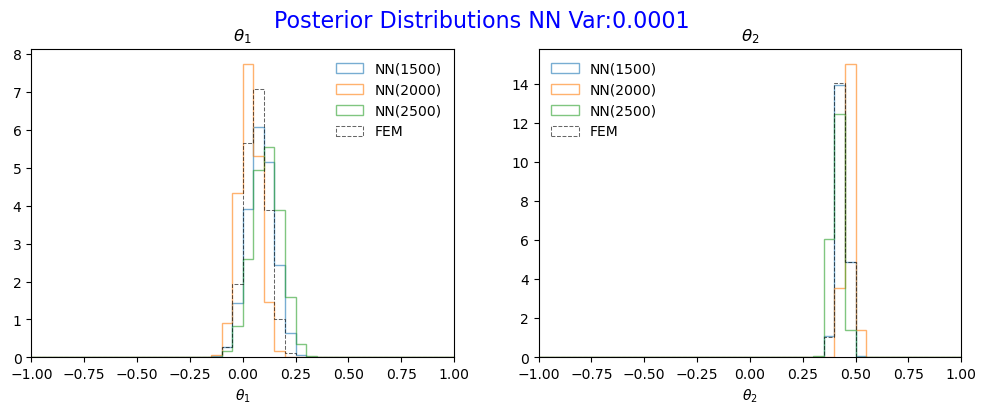

(1000000, 2)


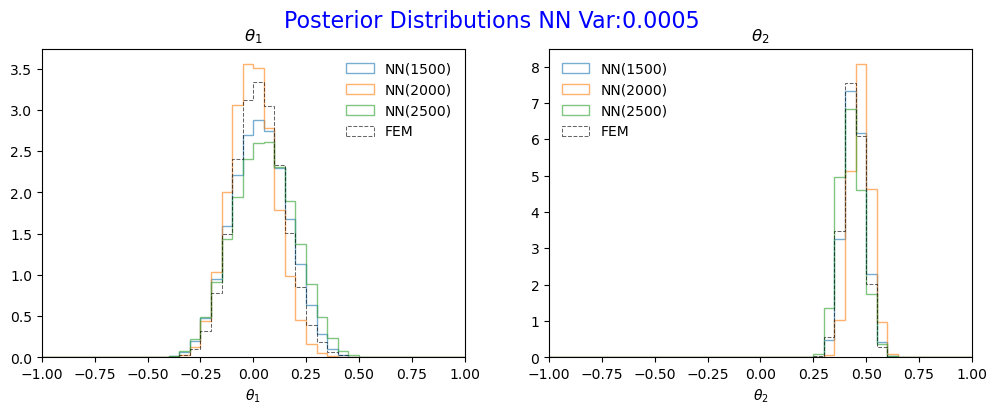

(1000000, 2)


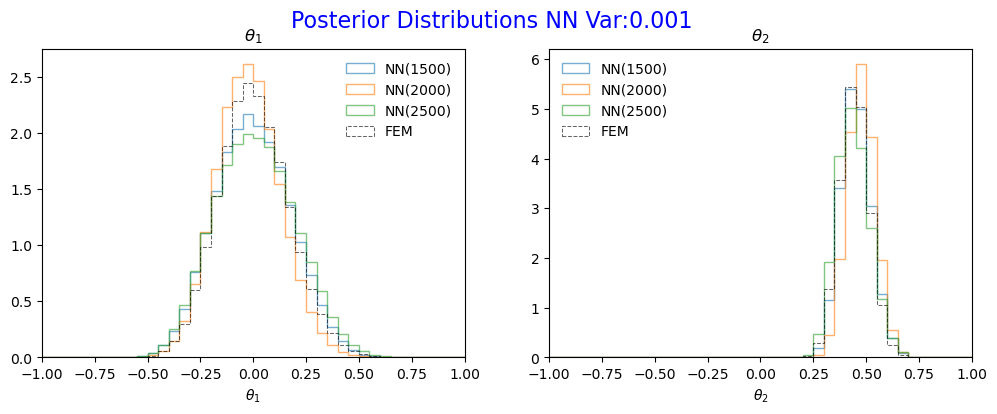

(1000000, 2)


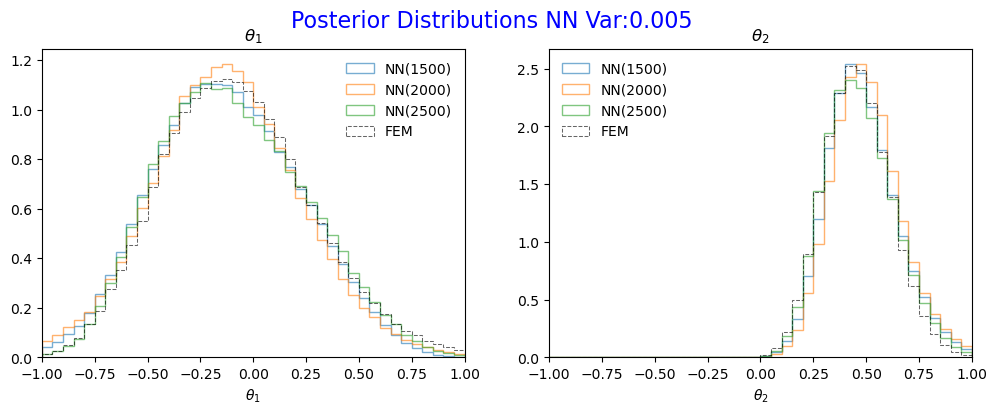

In [21]:
for vr in var:
    samp_num = np.load(f'./Models/FEM_pyro_h50_var{vr}_obs10.npy')
    print(samp_num.shape)
    
    samples = dict()

    for nobs in N:
        samples[nobs] = np.load(f'./Models/NN_var{vr}_hl{2}_w{20}_{nobs}_Samples_pyro_uniform.npy')

    plot_posterior_distributions(samples, N, samp_num,sufix="NN Var:" + str(vr))

(1000000, 2)


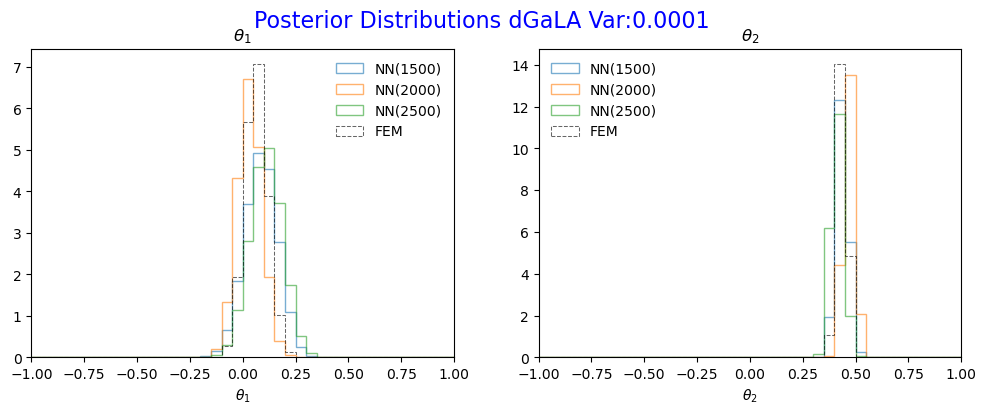

(1000000, 2)


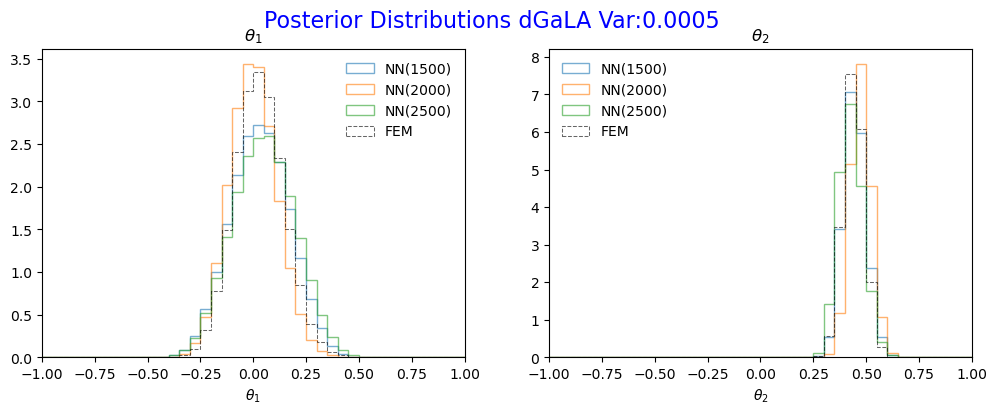

(1000000, 2)


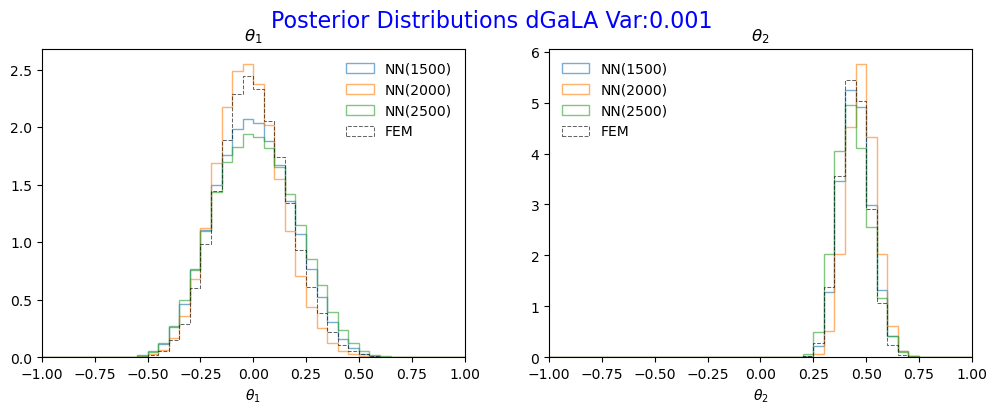

(1000000, 2)


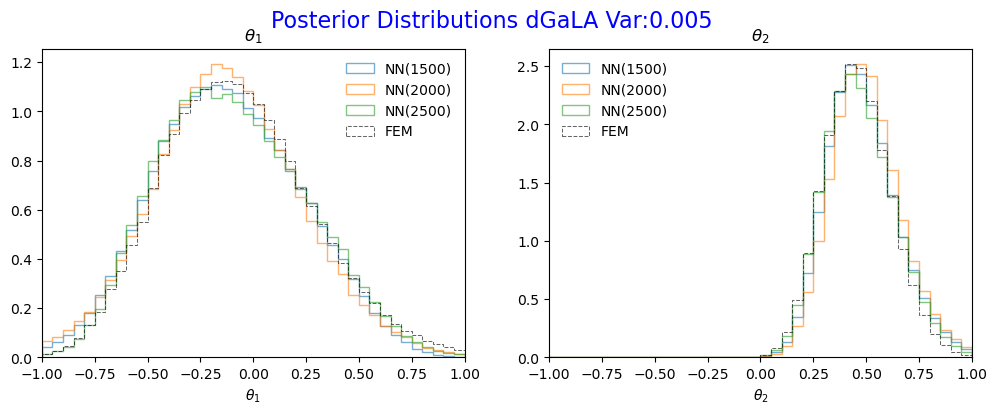

In [18]:
for vr in var:
    samp_num = np.load(f'./Models/FEM_pyro_h50_var{vr}_obs10.npy')
    print(samp_num.shape)
    samples = dict()

    for nobs in N:
        samples[nobs] = np.load(f'./Models/dGaLA2_hl{2}_w{20}_var{vr}_{nobs}_Samples_pyro_uniform.npy')

    plot_posterior_distributions(samples, N, samp_num,sufix="dGaLA Var:" + str(vr))

# NN 1 hidden layer

(1000000, 2)


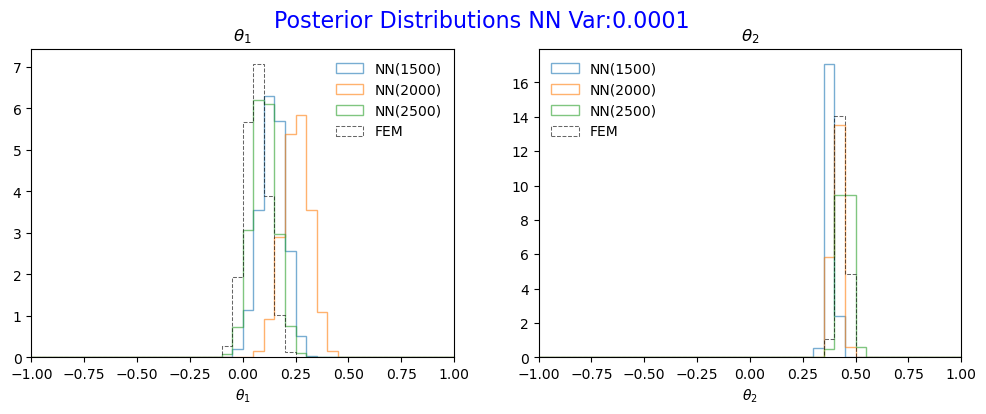

(1000000, 2)


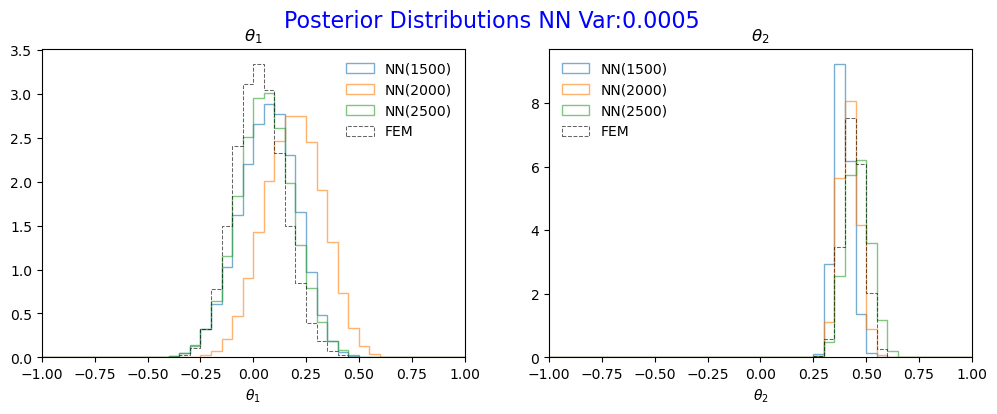

(1000000, 2)


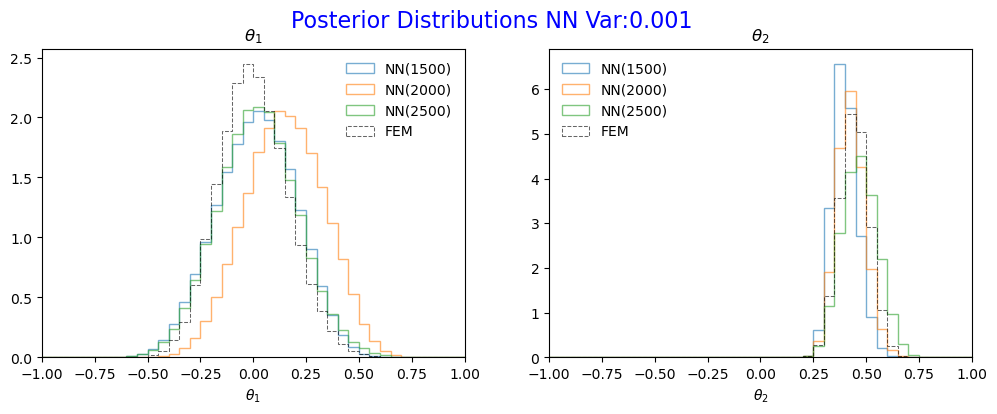

(1000000, 2)


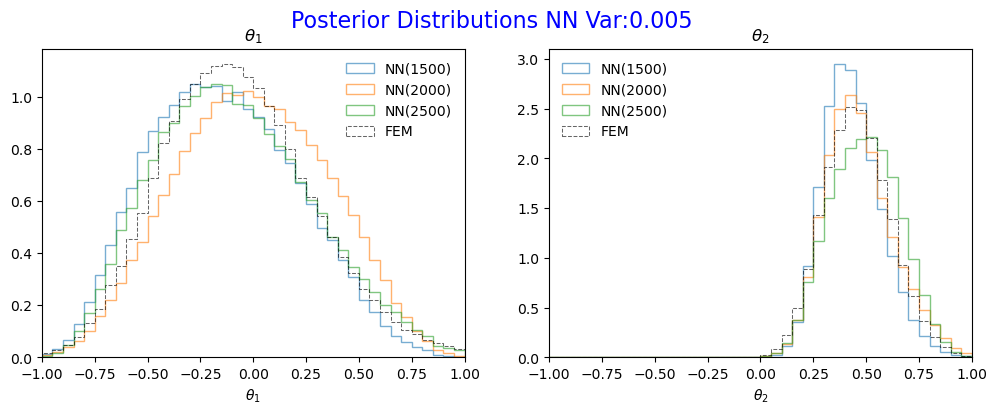

In [22]:
for vr in var:
    samp_num = np.load(f'./Models/FEM_pyro_h50_var{vr}_obs10.npy')
    print(samp_num.shape)
    samples = dict()

    for nobs in N:
        samples[nobs] = np.load(f'./Models/NN_var{vr}_hl{1}_w{50}_{nobs}_Samples_pyro_uniform.npy')

    plot_posterior_distributions(samples, N, samp_num,sufix="NN Var:" + str(vr))

(1000000, 2)


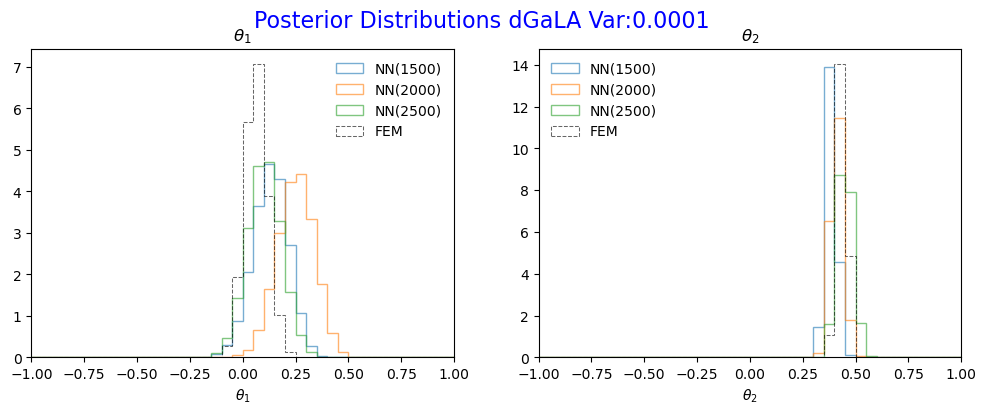

(1000000, 2)


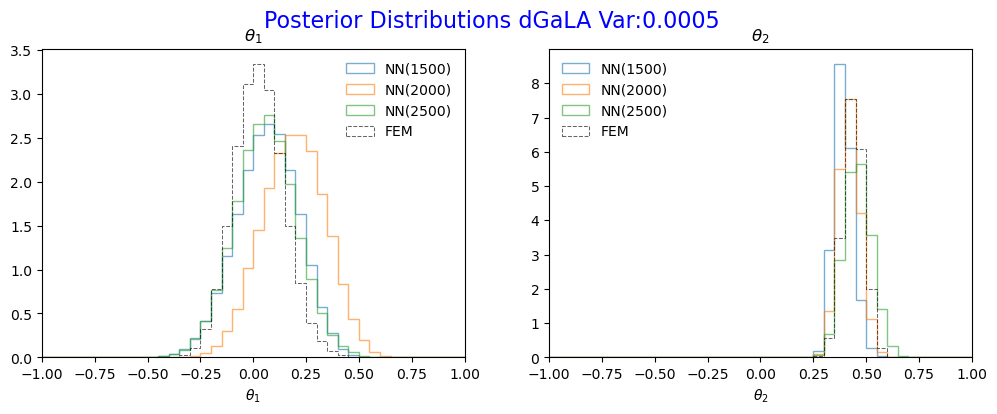

(1000000, 2)


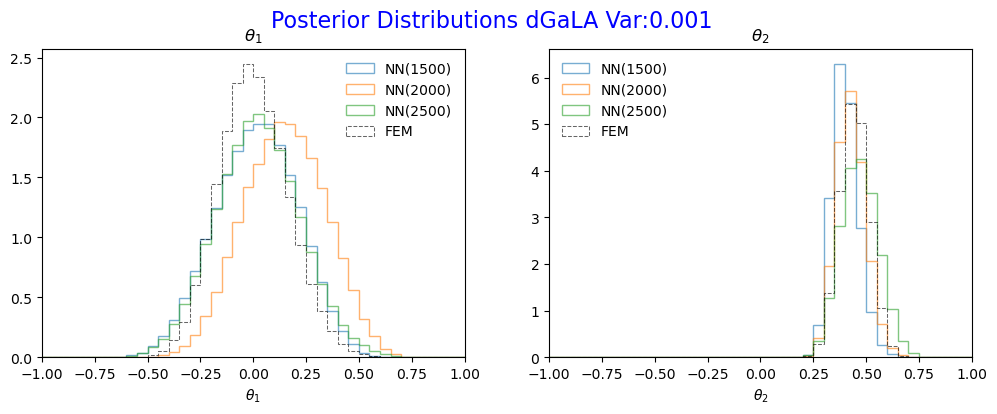

(1000000, 2)


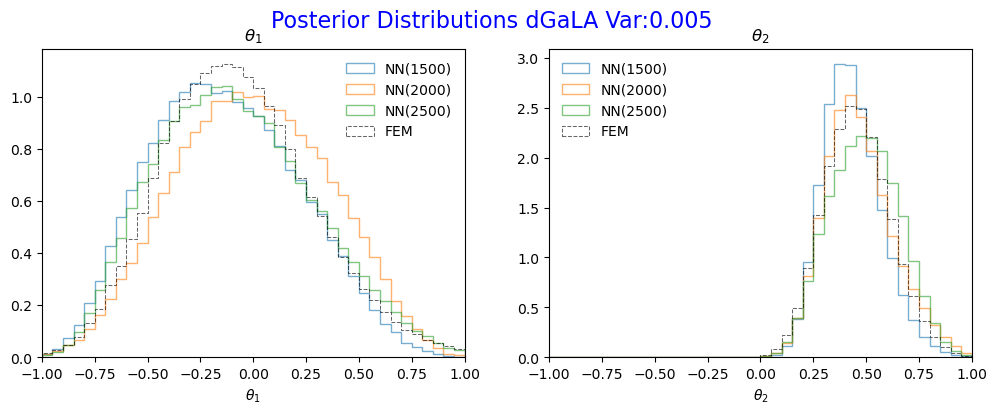

In [23]:
for vr in var:
    samp_num = np.load(f'./Models/FEM_pyro_h50_var{vr}_obs10.npy')
    print(samp_num.shape)
    samples = dict()

    for nobs in N:
        samples[nobs] = np.load(f'./Models/dGaLA2_hl{1}_w{50}_var{vr}_{nobs}_Samples_pyro_uniform.npy')

    plot_posterior_distributions(samples, N, samp_num,sufix="dGaLA Var:" + str(vr))

# NN 1 vs 2 hidden layer

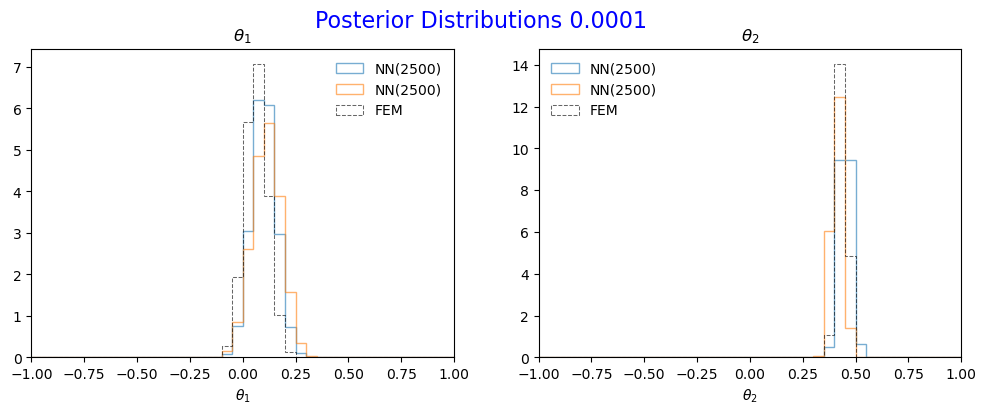

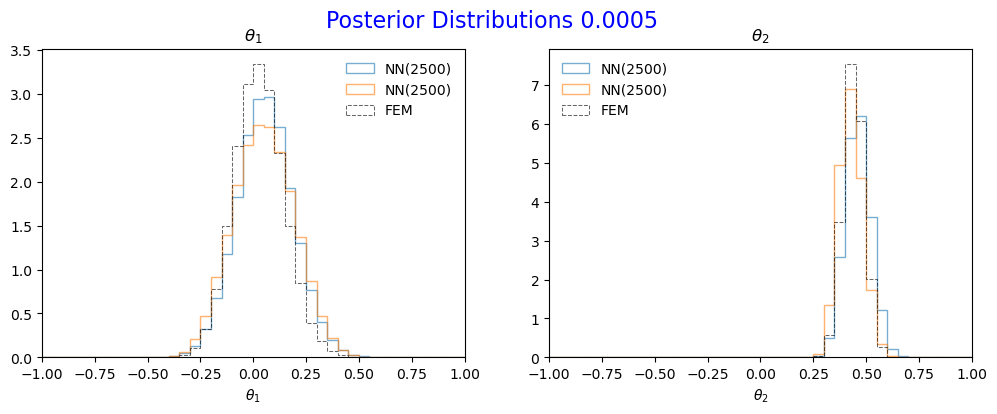

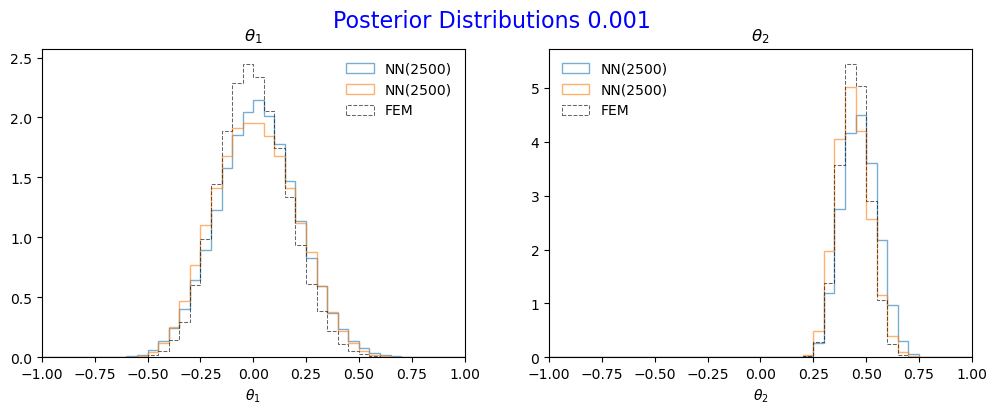

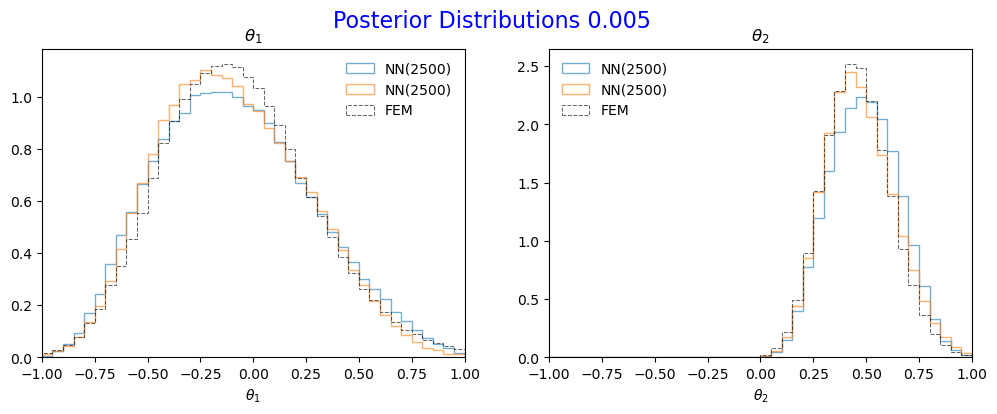

In [13]:
for vr in var:
    samp_num = np.load(f'./Models/FEM_pyro_h50_var{vr}_obs{10}.npy')


    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Posterior Distributions {vr}", color="blue", fontsize=16)
    plt.subplots_adjust(hspace=0.25)

    xbins = np.arange(-1, 1.1, 0.05)

    # Plotting for parameter 1
    for item in [(50,1,2500),(20,2,2500)]:
        w,hl,nobs = item
        samples = np.load(f'./Models/NN_var{vr}_hl{hl}_w{w}_{nobs}_Samples_pyro_uniform.npy')

        axs[0].hist(samples[:, 0], density=True,histtype='step', bins=xbins,
                    alpha=0.6,label=f"NN({str(nobs)})")

            # Plotting for parameter 2
        axs[1].hist(samples[:, 1], density=True, histtype='step',bins=xbins,
                    alpha=0.6, label=f"NN({str(nobs)})")
    
    axs[0].hist(samp_num[:, 0], density=True, alpha=0.6, histtype='step',bins=xbins,
                label="FEM", color="black", linestyle="--", linewidth=0.75)

    axs[1].hist(samp_num[:, 1], density=True, alpha=0.6, histtype='step',bins=xbins,
                label="FEM", color="black", linestyle="--", linewidth=0.75)

    axs[0].set_xlabel(r"$\theta_{1}$")
    axs[0].set_title(r"$\theta_1$")
    axs[0].legend(frameon=False)
    axs[0].set_xlim((-1,1))


    axs[1].set_xlabel(r"$\theta_{2}$")
    axs[1].set_title(r"$\theta_2$")
    axs[1].legend(frameon=False)
    axs[1].set_xlim((-1,1))

In [ ]:
# # Define the model using a coarse FEM solver
# def model(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):

#     lam = 0.001  # Set your lambda value for the Moreau-Yosida prior
#     moreau_prior = MoreauYosidaPrior(lam,device=device)

#     # Prior for the parameters theta (assuming 2 parameters)
#     theta = pyro.sample("theta", moreau_prior.expand([2]))

#     # Use a coarse mesh FEM solver as the surrogate model
#     surrogate_fem_solver.theta = theta.detach().cpu().numpy()  # Update the parameter vector

#     surrogate_fem_solver.uh = None

#     surrogate_fem_solver.solve()

#     # Get model predictions at the given points
#     model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

#     # Likelihood: Gaussian likelihood with a fixed standard deviation
#     y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

#     return y


# def model_dgala(surrogate,synthetic_data, points, sig,device='cpu'):

#     lam = 0.001  # Set your lambda value for the Moreau-Yosida prior
#     moreau_prior = MoreauYosidaPrior(lam,device=device)

#     # Prior for the parameters theta (assuming 2 parameters)
#     theta = pyro.sample("theta", moreau_prior.expand([2]))

#     data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

#     surg_mu, surg_sigma = surrogate(data_test)

#     surg_mu = surg_mu.view(-1, 1)

#     surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

#     sigma = sig ** 2 + surg_sigma

#     # Likelihood: Gaussian likelihood with a fixed standard deviation
#     y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

#     return y

# def model_nn(surrogate,synthetic_data, points, sig,device='cpu'):

#     lam = 0.001  # Set your lambda value for the Moreau-Yosida prior
#     moreau_prior = MoreauYosidaPrior(lam,device=device)

#     # Prior for the parameters theta (assuming 2 parameters)
#     theta = pyro.sample("theta", moreau_prior.expand([2]))

#     data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

#     surg_mu = surrogate(data_test)

#     surg_mu = surg_mu.view(-1, 1)

#     # Likelihood: Gaussian likelihood with a fixed standard deviation
#     y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

#     return y

# Samples own code

In [ ]:
obs = 10
theta_th=np.array([0.098, 0.430])
mean, var = 0,[1e-4,5e-4,1e-3,5e-3]


# for vr in var:
#     st = np.sqrt(vr)
#     obs_points, obs_sol = generate_noisy_obs(obs, theta_t=theta_th, mean=mean, std=st,vert=200)

#     sampler = MetropolisHastingsSampler(obs_points, obs_sol, sig = st,numerical = True, vert=50)

#     samp_num,dt_tracker_num = sampler.run_sampler(n_chains=1000000)

#     np.save(f'./Models/FEM_var{vr}_adam_Samples.npy', samp_num)

#     for nobs in N:
#         layers = [3] + 1*[20] + [1]     
#         model = DNN(layers)
#         model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_w20_N{nobs}_batch150.pt"))
#         model.eval()        

#         sampler = MetropolisHastingsSampler(obs_points, obs_sol,surrogate=model, sig = st)
#         nsamples, dt_progres = sampler.run_sampler(n_chains=1050000)
        
#         np.save(f'./Models/NN_var{vr}_{nobs}_Samples.npy', nsamples)


#         ##### Deep GaLA
#         data_int,left_bc,right_bc = generate_data(nobs)
#         data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

#         pde = {"PDE":["de","bc_l","bc_r"], 
#             "data_set":{"de" : Variable(data_int,requires_grad=True),
#             "bc_l":left_bc,
#             "bc_r" :right_bc}}
        
#         llp = llaplace(model)
#         llp.fit(pde=pde, hessian_structure = "full")

#         log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
#         hyper_optimizer = torch.optim.Adam([log_prior.to(device), log_sigma.to(device)], lr=1e-2)

#         error = 1.0  # Initialize error to start the loop
#         n_iter = 0

#         while error > 1e-3 or n_iter == 3000:
#             # Clone the values at the start of the iteration to use later for error calculation
#             prev_log_prior, prev_log_sigma = log_prior.clone(), log_sigma.clone()

#             hyper_optimizer.zero_grad()

#             # Calculate negative marginal likelihood
#             neg_marglik = -llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
#             neg_marglik.backward(retain_graph=True)

#             # Perform optimization step
#             hyper_optimizer.step()

#             # Calculate error directly in PyTorch
#             error = 0.5 * (torch.abs(log_prior - prev_log_prior) + torch.abs(log_sigma - prev_log_sigma)).item()
#             n_iter +=1

#         sampler = MetropolisHastingsSampler(obs_points, obs_sol,surrogate=llp, sig = st, mean=False)
#         nsamples, dt_progres = sampler.run_sampler(n_chains=1050000)
        

#         np.save(f'./Models/dGaLA_var{vr}_{nobs}_Samples.npy', nsamples)

In [ ]:
for vr in var:
    samp_num = np.load(f'./Models/FEM_var{vr}_adam_Samples.npy')
    print(samp_num.shape)
    samples = dict()

    for nobs in N:
        samples[nobs] = np.load(f'./Models/NN_var{vr}_{nobs}_Samples.npy')

    plot_posterior_distributions(samples, N, samp_num,sufix="Var:" + str(vr))

In [ ]:
for vr in var:
    samp_num = np.load(f'./Models/FEM_var{vr}_adam_Samples.npy')
    print(samp_num.shape)
    samples = dict()

    for nobs in N:
        samples[nobs] = np.load(f'./Models/dGaLA_var{vr}_{nobs}_Samples.npy')

    plot_posterior_distributions(samples, N, samp_num,sufix="dGaLA Var:" + str(vr))